<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Contrôle-de-la-qualité-des-datasets" data-toc-modified-id="Contrôle-de-la-qualité-des-datasets-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Contrôle de la qualité des datasets</a></span><ul class="toc-item"><li><span><a href="#Rapide-EDA" data-toc-modified-id="Rapide-EDA-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Rapide EDA</a></span><ul class="toc-item"><li><span><a href="#Correlation" data-toc-modified-id="Correlation-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Correlation</a></span></li><li><span><a href="#Distributions-&quot;normales&quot;" data-toc-modified-id="Distributions-&quot;normales&quot;-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Distributions "normales"</a></span></li><li><span><a href="#Certaines-variables-ont-une-distribution-skewed" data-toc-modified-id="Certaines-variables-ont-une-distribution-skewed-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Certaines variables ont une distribution skewed</a></span></li><li><span><a href="#Traitement-de-la-variable-SBATI" data-toc-modified-id="Traitement-de-la-variable-SBATI-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Traitement de la variable SBATI</a></span></li><li><span><a href="#Un-regard-sur-notre-variable-cible-prix_m_c" data-toc-modified-id="Un-regard-sur-notre-variable-cible-prix_m_c-1.1.5"><span class="toc-item-num">1.1.5&nbsp;&nbsp;</span>Un regard sur notre variable cible prix_m_c</a></span></li></ul></li><li><span><a href="#Vérification-des-données" data-toc-modified-id="Vérification-des-données-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Vérification des données</a></span></li></ul></li><li><span><a href="#Sélection-des-features" data-toc-modified-id="Sélection-des-features-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Sélection des features</a></span><ul class="toc-item"><li><span><a href="#A-l'aide-d'un-LassoCV" data-toc-modified-id="A-l'aide-d'un-LassoCV-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>A l'aide d'un LassoCV</a></span><ul class="toc-item"><li><span><a href="#Quésako-?" data-toc-modified-id="Quésako-?-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Quésako ?</a></span></li><li><span><a href="#Les-principales-features" data-toc-modified-id="Les-principales-features-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Les principales features</a></span></li><li><span><a href="#Les-features-d'importance" data-toc-modified-id="Les-features-d'importance-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Les features d'importance</a></span></li></ul></li><li><span><a href="#A-l'aide-d'un-RandomForestRegressor-naif" data-toc-modified-id="A-l'aide-d'un-RandomForestRegressor-naif-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>A l'aide d'un RandomForestRegressor naif</a></span></li></ul></li><li><span><a href="#Développement-de-la-Pipeline-avec-XGBoost-et-LGBoosting" data-toc-modified-id="Développement-de-la-Pipeline-avec-XGBoost-et-LGBoosting-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Développement de la Pipeline avec XGBoost et LGBoosting</a></span><ul class="toc-item"><li><span><a href="#Feature-selection-RandomForest" data-toc-modified-id="Feature-selection-RandomForest-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Feature selection RandomForest</a></span></li><li><span><a href="#Feature-selection-Lasso" data-toc-modified-id="Feature-selection-Lasso-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Feature selection Lasso</a></span></li><li><span><a href="#Sans-feature-selection" data-toc-modified-id="Sans-feature-selection-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Sans feature selection</a></span></li></ul></li></ul></div>

In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

import xgboost as xgb
from lightgbm import LGBMRegressor

import math
from scipy.stats import skewnorm
import scipy

import warnings
warnings.filterwarnings("ignore")

In [182]:
train= pd.read_csv("../good_data/donnees_model/donnees_train.csv")
test= pd.read_csv("../good_data/donnees_model/donnees_test.csv")
valid= pd.read_csv("../good_data/donnees_model/donnees_validation.csv")

In [183]:
# AU cas ou
train= train[train["valfoncact"] !=0]
test= test[test["valfoncact"] !=0]
valid= valid[valid["valfoncact"] !=0]

In [184]:
train= pd.concat([train, valid])

In [185]:
def lets_go(df):
#     df["arrondissement"] = df["arrondissement"].astype("category")
#     df["pp"] = df["pp"].astype("category")
    df["mois"] = df["datemut"].str[5:7]#.astype("category")
    donnees_V2 = df.drop(columns = ["nblot", "nbpar", "nblocmut", "nblocdep","datemut"])
#     donnees_V2= pd.get_dummies(donnees_V2, columns= ["arrondissement", "pp", "mois"])
    return donnees_V2

In [186]:
train= lets_go(train)
test= lets_go(test)

In [187]:
# System variable / for model training
n_jobs= 10
verbose= 1

In [188]:
train["prix_m_c"]= train["valfoncact"] / train["sbati"]

log_transfo= lambda x: np.log(x) if x > 0 else 1

train["log_prix_m_c"]= train["prix_m_c"].apply(log_transfo)

In [189]:
test["prix_m_c"]= test["valfoncact"] / test["sbati"]
test["log_prix_m_c"]= test["prix_m_c"].apply(log_transfo)

## Contrôle de la qualité des datasets

### Rapide EDA

#### Correlation

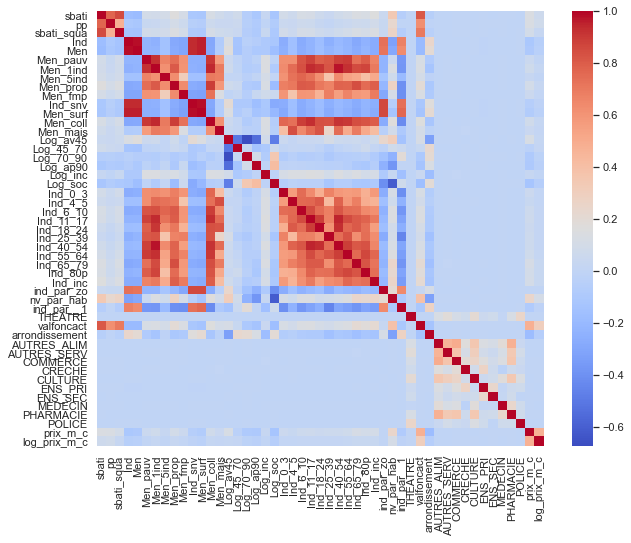

In [190]:
fig= plt.figure(figsize= (10 ,8))
corr_to_plot= train.drop(columns= ["Unnamed: 0", "idmutation"])

corr = corr_to_plot.corr()

sns.heatmap(corr, 
            xticklabels= corr.columns.values
            , yticklabels= corr.columns.values
            , cmap='coolwarm')
plt.show()

Les variables Ind, qui représentent les proportions d'individus par tranche d'age est fortement corrélé aux nombres de personne par ménage en moyenne. Sinon, l'analyse est la même que celle dans le notebook analyse_and_treat.

On va enlever **sbati**, qui est trop corrélé à la variable cible.

#### Distributions "normales"

In [191]:
def compare_hist_to_norm_ax(x, data, title, bins=25):
    """
    Développé dansle cadre du projet tsNostradamus 
    https://github.com/Orlogskapten/tsNostradamus/blob/master/src/nostradamus/utils/normal_hist.py
    """

    mu, std = scipy.stats.norm.fit(data)

    ax[x].hist(data, bins=bins, density=True, alpha=0.6, color='orange', label="Données")

    # Plot le PDF.
    xmin, xmax = (data.min(), data.max())
    X = np.linspace(xmin, xmax)

    ax[x].plot(X, scipy.stats.norm.pdf(X, mu, std), label="Normal Distribution")
    ax[x].plot(X, skewnorm.pdf(X, *skewnorm.fit(data)), color='black', label="Skewed Normal Distribution")
    
    ax[x].set_title(title)
    labels = [item.get_text() for item in ax[x].get_xticklabels()]

    empty_string_labels = ['']*len(labels)
    ax[x].set_xticklabels(empty_string_labels)
    pass

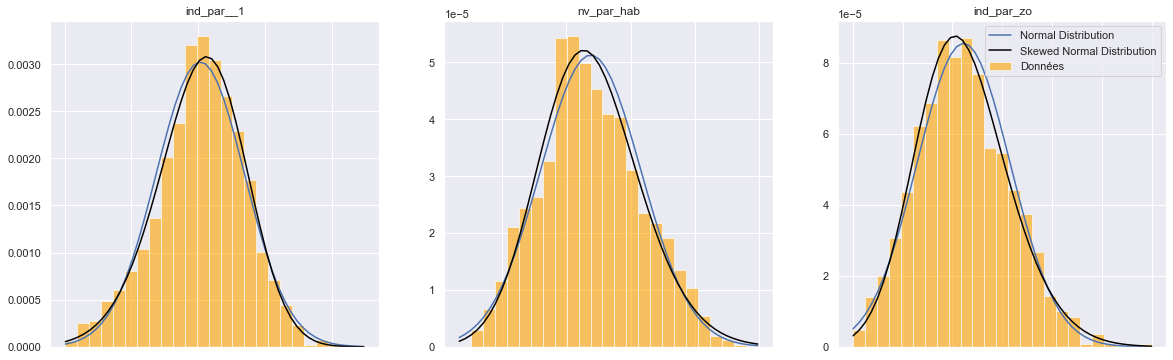

In [192]:
norm_var= ["ind_par__1", "nv_par_hab", "ind_par_zo"]
fig, ax= plt.subplots(1, 3, figsize= (20, 6))

for i in range(3):
    compare_hist_to_norm_ax(x= i, data= corr_to_plot[norm_var[i]]
                            , title= norm_var[i])
    
ax[2].legend() # affiche la légende
plt.show()

Ce sont les rares variables qui sont semblent suivre une loi normale (skewed proche de la loi normale);

C'est pas forcément utile pour nos algo d'avoir une distribution de nos données normale, ni pour les algo de feature selection.

#### Certaines variables ont une distribution skewed

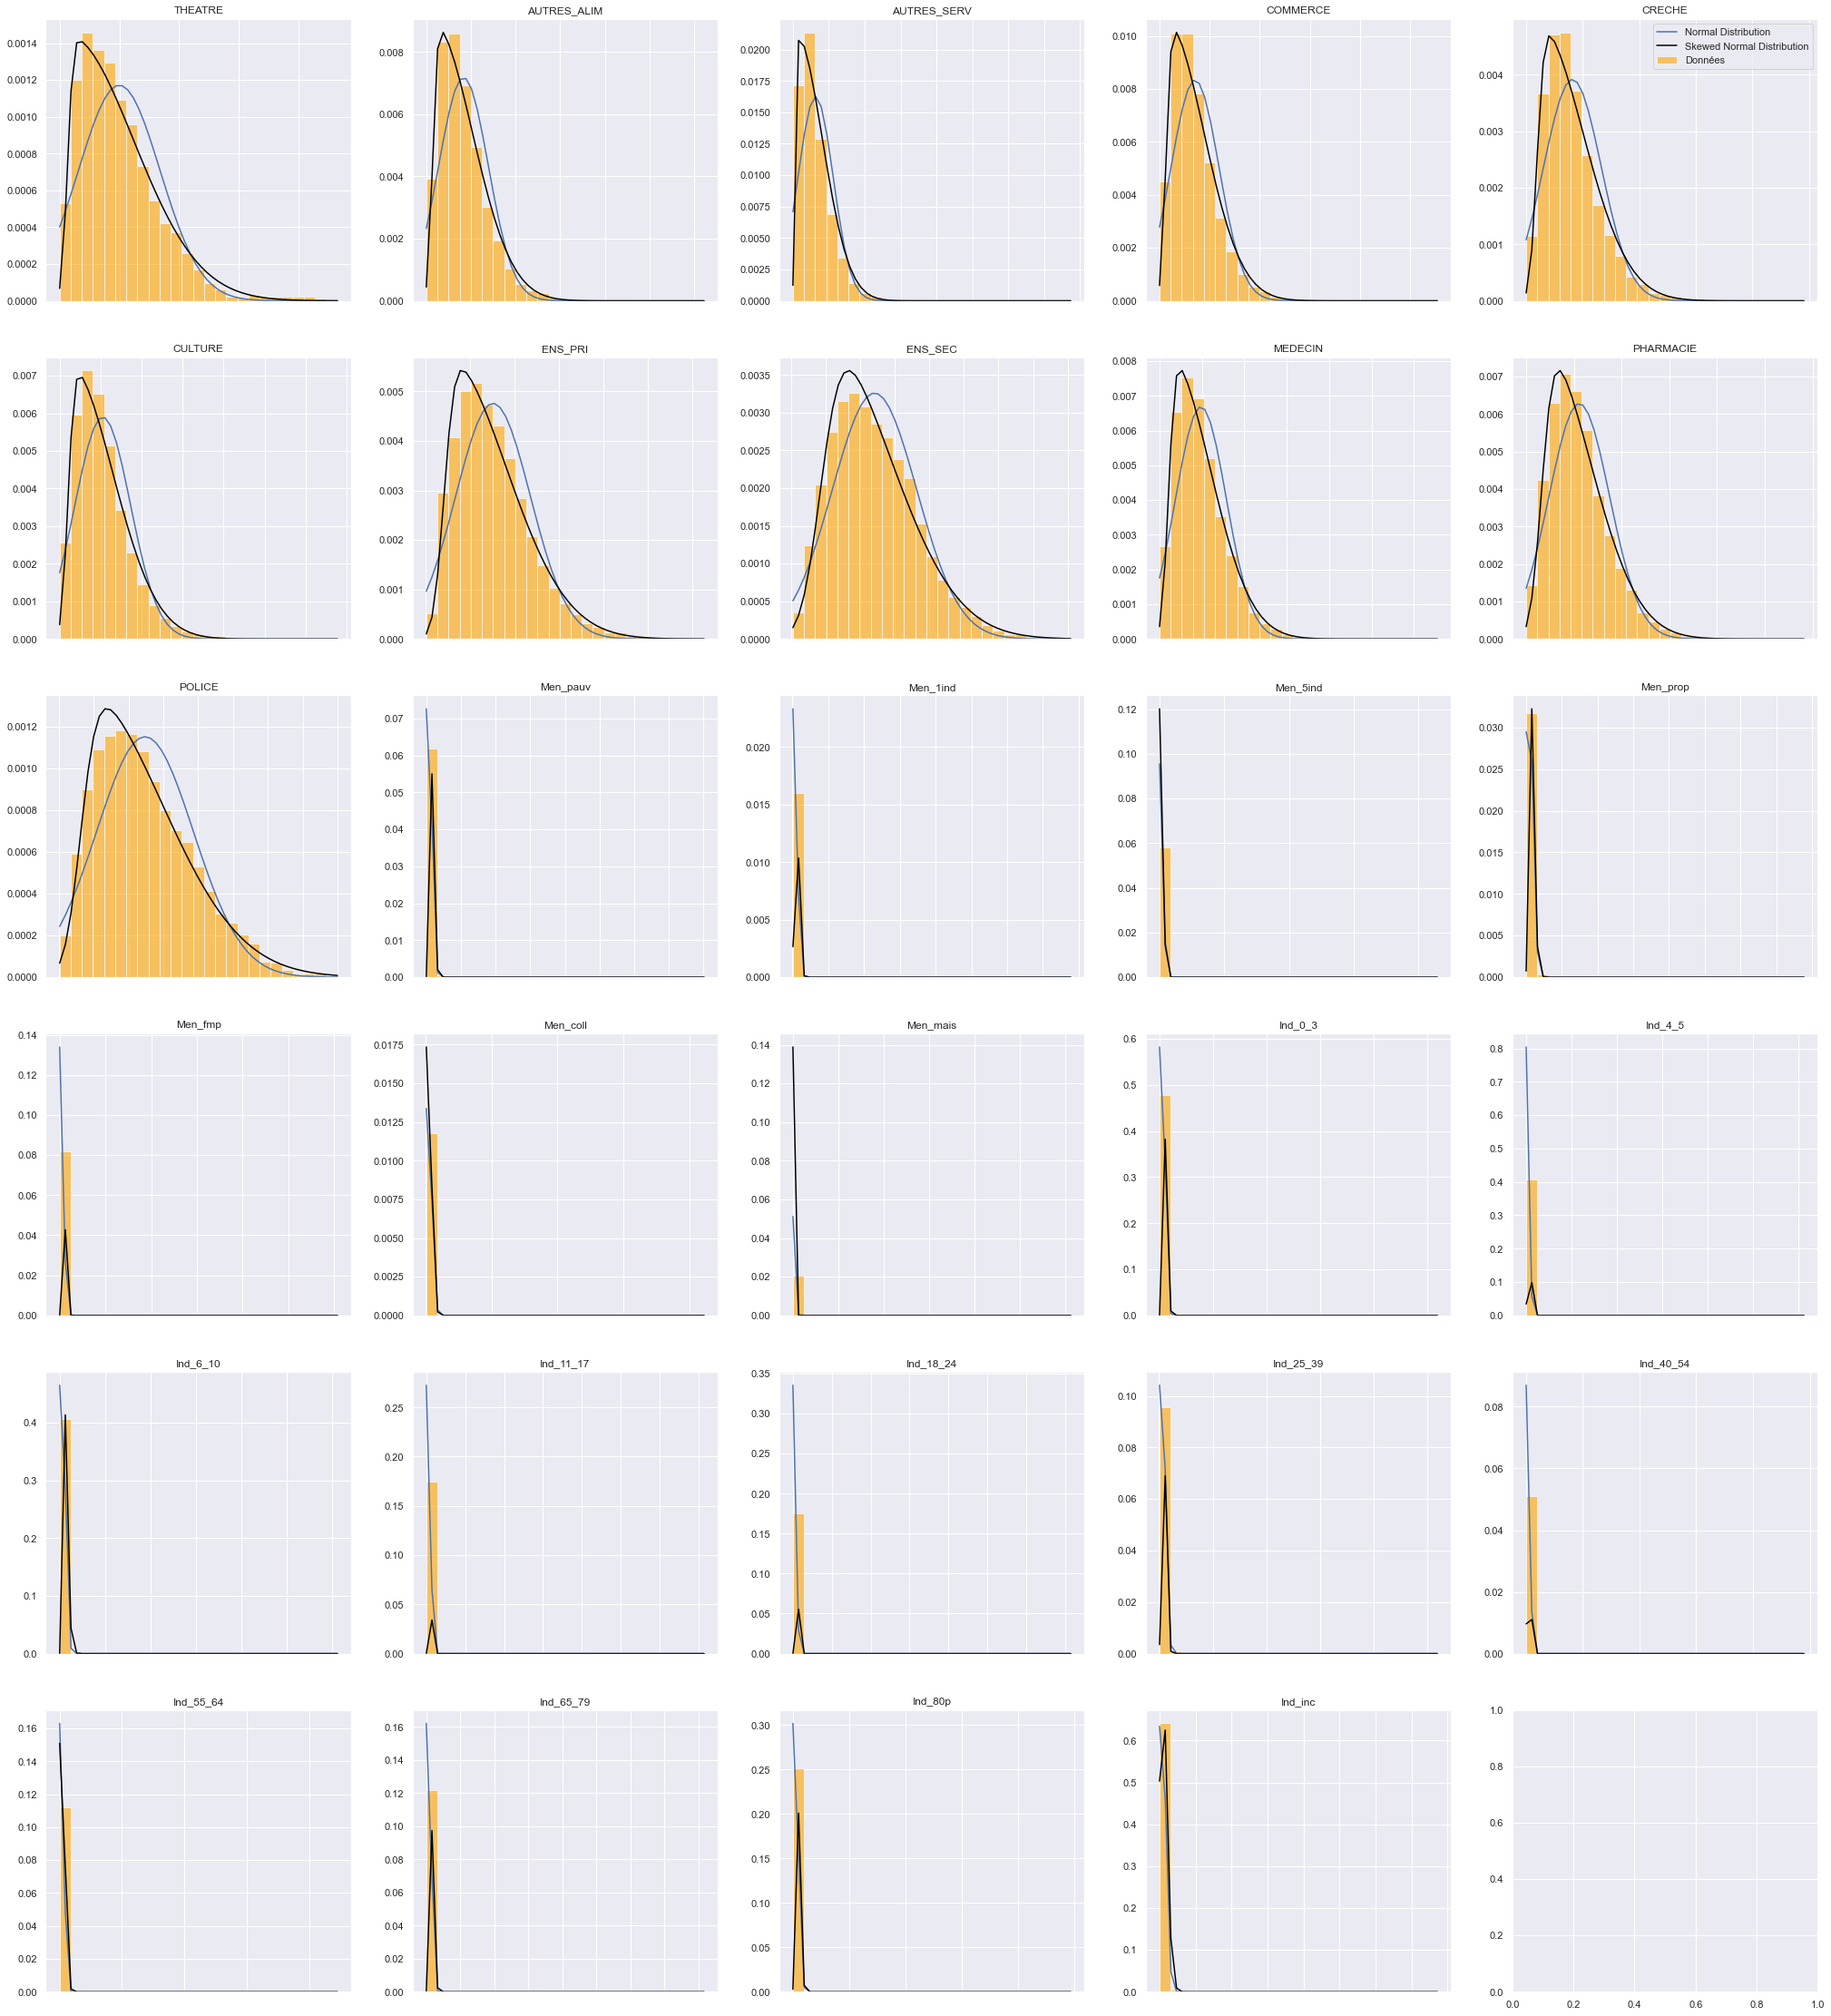

In [193]:
var_skew= ["THEATRE", "AUTRES_ALIM", "AUTRES_SERV"
          , "COMMERCE", "CRECHE", "CULTURE", "ENS_PRI", "ENS_SEC", "MEDECIN", "PHARMACIE"
          , "POLICE", "Men_pauv", "Men_1ind", "Men_5ind", "Men_prop", "Men_fmp", "Men_coll", "Men_mais", "Ind_0_3"
          , "Ind_4_5", "Ind_6_10", "Ind_11_17", "Ind_18_24", "Ind_25_39", "Ind_40_54", "Ind_55_64"
          , "Ind_65_79", "Ind_80p", "Ind_inc"]

fig, ax= plt.subplots(6, 5, figsize= (35, 40))

for i in range(6):
    try:
        compare_hist_to_norm_ax(x= (i, 0), data= corr_to_plot[var_skew[5*i]]
                                , title= var_skew[5*i])
        compare_hist_to_norm_ax(x= (i, 1), data= corr_to_plot[var_skew[5*i+1]]
                                , title= var_skew[5*i+1])
        compare_hist_to_norm_ax(x= (i, 2), data= corr_to_plot[var_skew[5*i+2]]
                                , title= var_skew[5*i+2])
        compare_hist_to_norm_ax(x= (i, 3), data= corr_to_plot[var_skew[5*i+3]]
                                , title= var_skew[5*i+3])
        compare_hist_to_norm_ax(x= (i, 4), data= corr_to_plot[var_skew[5*i+4]]
                                , title= var_skew[5*i+4])
    except IndexError:
        pass
    
    
ax[0, 4].legend() # affiche la légende
plt.show()

Les variables qui distinguent les distances du logement vers un service X semblent suivre notre loi normale skewed; ce qui peut sembler logique à Paris. Ce qui pourrait être sympa c'est de savoir si les observations en bout de queues de la distribution sont toujours similaires (i.e les mêmes logements n sont loins des services).

In [194]:
# Final
log_var_skew= ["log_"+i for i in var_skew]

 # je saispas pk le apply marche pas ptn
# train[log_var_skew]= train[var_skew].apply(log_transfo)
for i in var_skew:
    train["log_"+i]= train[i].apply(log_transfo)
    test["log_"+i]= test[i].apply(log_transfo)

train.drop(columns= var_skew, inplace= True)
test.drop(columns= var_skew, inplace= True)

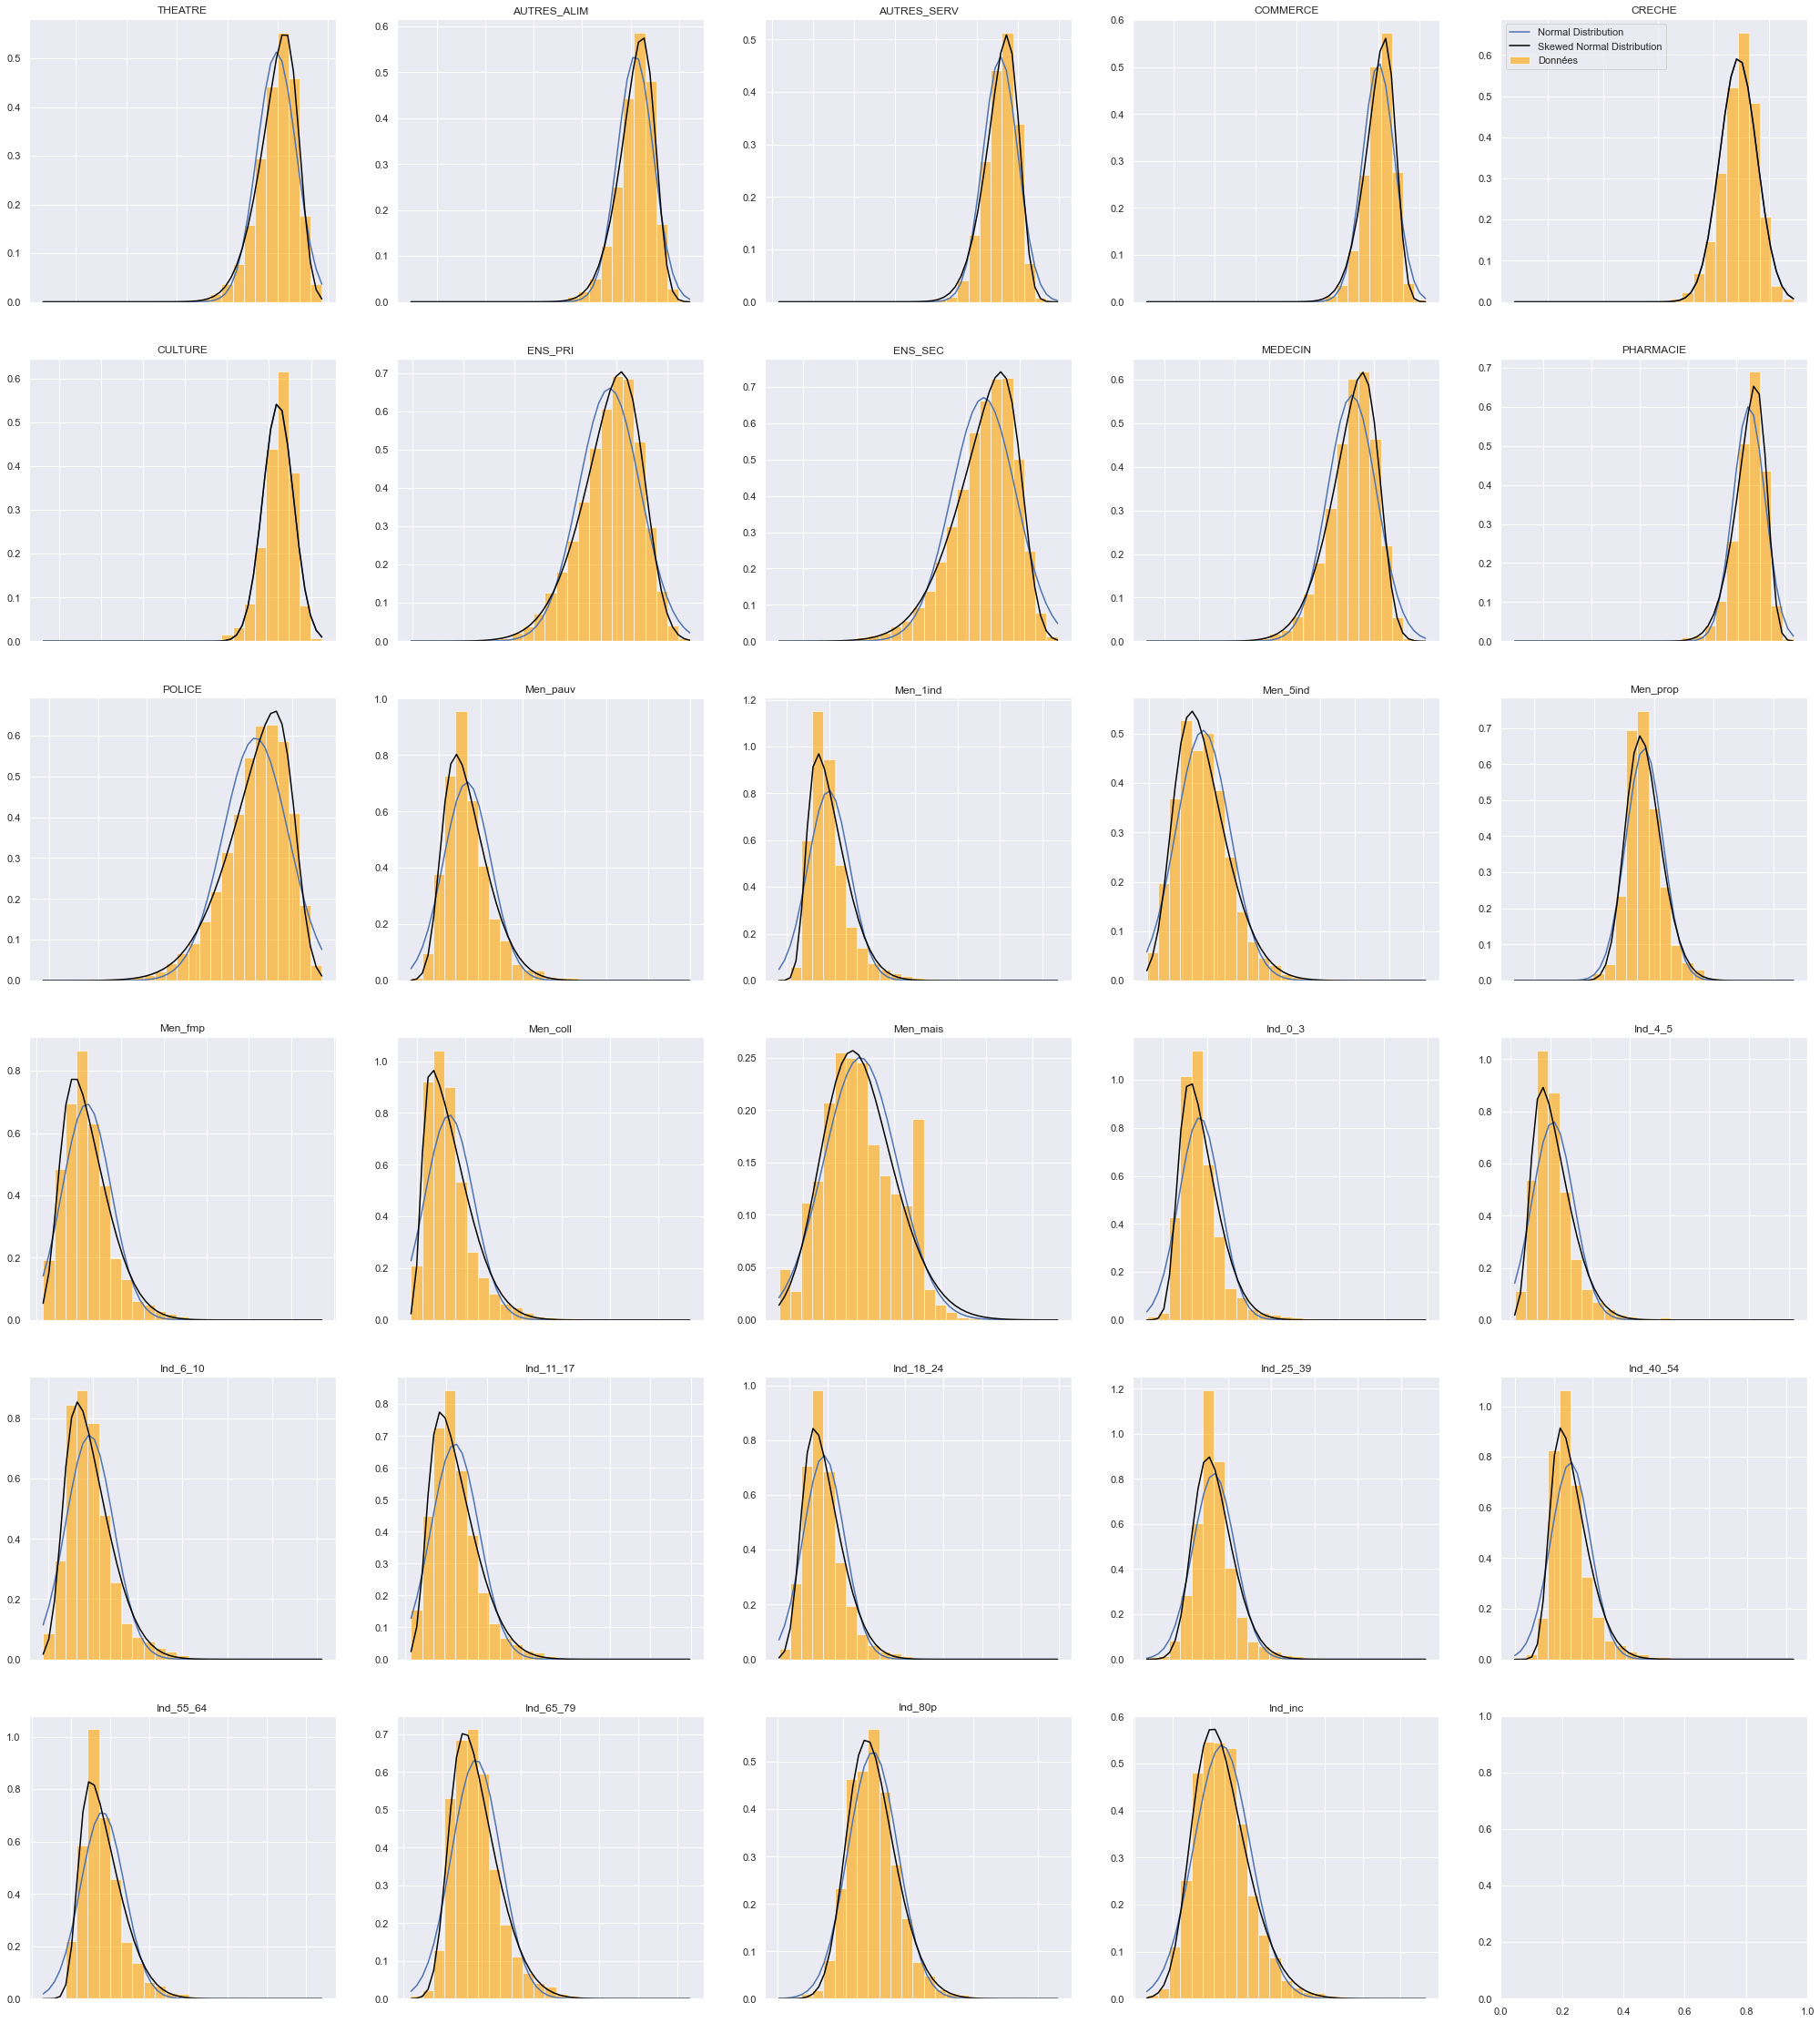

In [195]:
fig, ax= plt.subplots(6, 5, figsize= (35, 40))

for i in range(6):
    try:
        compare_hist_to_norm_ax(x= (i, 0), data= train[log_var_skew[5*i]]
                                , title= var_skew[5*i])
        compare_hist_to_norm_ax(x= (i, 1), data= train[log_var_skew[5*i+1]]
                                , title= var_skew[5*i+1])
        compare_hist_to_norm_ax(x= (i, 2), data= train[log_var_skew[5*i+2]]
                                , title= var_skew[5*i+2])
        compare_hist_to_norm_ax(x= (i, 3), data= train[log_var_skew[5*i+3]]
                                , title= var_skew[5*i+3])
        compare_hist_to_norm_ax(x= (i, 4), data= train[log_var_skew[5*i+4]]
                                , title= var_skew[5*i+4])
    except IndexError:
        pass

ax[0, 4].legend() # affiche la légende
plt.show()

Sachant que modifier nos données de cette façon ne change pas la prédiction (avec nos modèles), on fait une transformation log pour manipuler un peu nos données.

In [196]:
# supression des outliers 
quantile= 0.999
all_coll= [i for i in train.columns if train[i].dtypes == "float"]

print(train.shape)
for i in all_coll:
    q= train[i].quantile(quantile)
    train= train[train[i] < q]
    
    q= test[i].quantile(quantile)
    test= test[test[i] < q]
    
print(train.shape)

(142152, 52)
(134296, 52)


#### Traitement de la variable SBATI

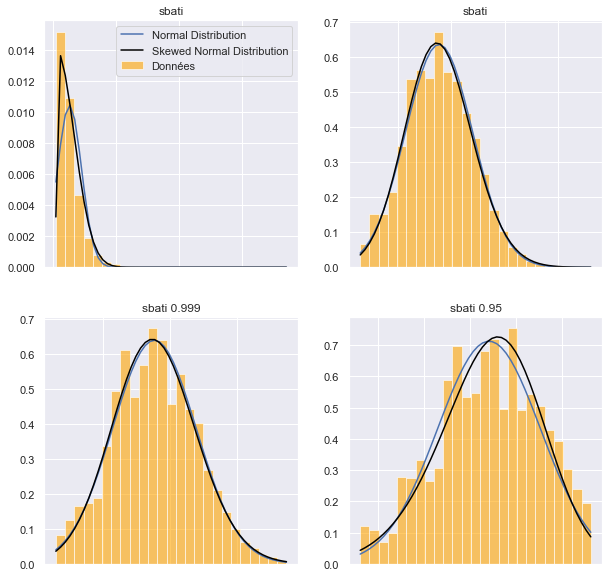

In [197]:
fig, ax= plt.subplots(2, 2, figsize= (10, 10))

compare_hist_to_norm_ax(x= (0, 0), data= train["sbati"]
                                , title= "sbati")

log_transfo_sbati= train["sbati"].apply(lambda x: np.log(x) if x > 0 else 1)
compare_hist_to_norm_ax(x= (0, 1), data= log_transfo_sbati
                                , title= "sbati")

quantiles= [0.999, 0.95]
for i in range(2):
    log_transfo_sbati= train["sbati"].apply(lambda x: np.log(x) if x > 0 else 1)
    log_transfo_sbati= log_transfo_sbati[log_transfo_sbati < log_transfo_sbati.quantile(quantiles[i])]
    
    compare_hist_to_norm_ax(x= (1, i), data= log_transfo_sbati
                                , title= "sbati {}".format(quantiles[i]))
    
ax[0, 0].legend(loc= 1) # affiche la légende loc = 9 == upper right
plt.show()

On va transformer la variable sbati, qui est très corrélé à notre variable cible.

In [198]:
print(train.shape)
train["sbati"]= train["sbati"].apply(lambda x: np.log(x) if x > 0 else 1)
train= train[train["sbati"] < train["sbati"].quantile(quantile)]
print(train.shape)

test["sbati"]= test["sbati"].apply(lambda x: np.log(x) if x > 0 else 1)
test= test[test["sbati"] < test["sbati"].quantile(quantile)]

(134296, 52)
(134161, 52)


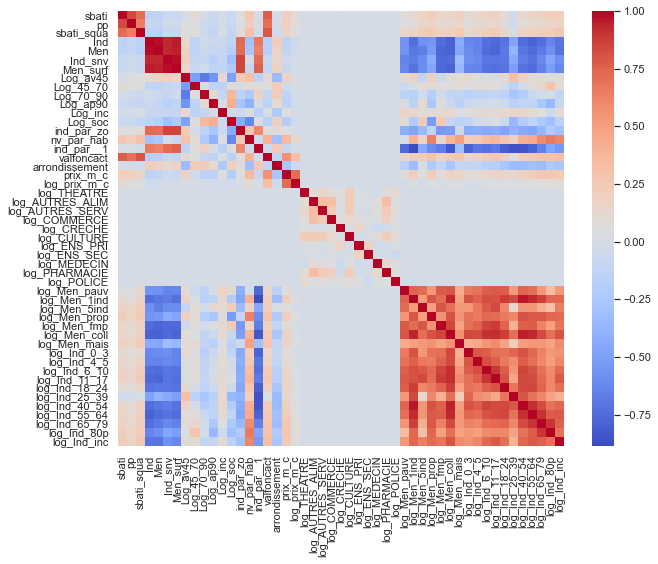

In [199]:
fig= plt.figure(figsize= (10 ,8))
corr_to_plot= train.drop(columns= ["Unnamed: 0", "idmutation"])

corr = corr_to_plot.corr()

sns.heatmap(corr, 
            xticklabels= corr.columns.values
            , yticklabels= corr.columns.values
            , cmap='coolwarm')
plt.show()

On est content, on a réussi à réduire la corrélation entre sbati et prix_m_c à l'aide :
- de la log transformation
- de la suppression des outliers
- de la variable prix_m_c au lieu de valfoncact

#### Un regard sur notre variable cible prix_m_c

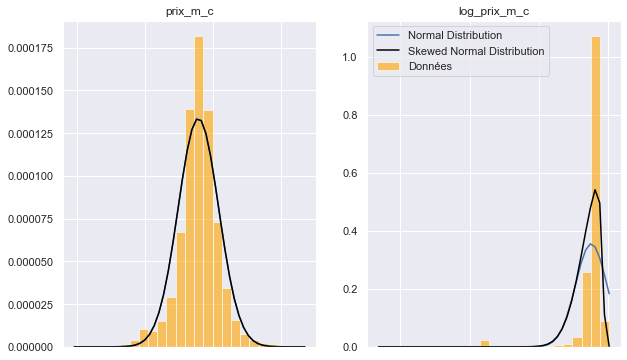

In [200]:
fig, ax= plt.subplots(1, 2, figsize= (10, 6))

compare_hist_to_norm_ax(x=  0, data= train["prix_m_c"]
                                , title= "prix_m_c")
compare_hist_to_norm_ax(x=  1, data= train["log_prix_m_c"]
                                , title= "log_prix_m_c")
ax[1].legend() 

La distribution initiale semble suivre une loi normale ==> la log transformation c'est overkill ici.

### Vérification des données

In [201]:
def dim_df(df):
    return df.shape[0], df.shape[1]

# Check we have the same number of col
assert dim_df(train)[1] == dim_df(test)[1]

In [202]:
# To iterate dataset into for bound
stock_dico= {"train": train, "test": test, "valid": valid}
listed_index= [i for i in stock_dico.keys()]
# Some column are useless 
useless_col= ["Unnamed: 0", "idmutation", "FR", "Ind", "irl", "geometry", "year"
             , "valeurfo_1", "valeurfo_2", "valeurfo_3", "rate_cumpr", "IdINSPIRE", "datemut"
             , "l_codinsee", "libtypbien", "sbati_squa", "log_prix_m_c", "valfoncact"]#, "sbati"]

sbati_train= train["sbati"].copy()
sbati_test= test["sbati"].copy()


not_object_col1= [i for i in train.columns if train[i].dtypes != "object" and i not in useless_col]

not_object_col= [i for i in not_object_col1 if i not in ["arrondissement", "pp", "mois"]]
print(not_object_col)
print("\nOn a {} colonne à analyser".format(len(not_object_col)))

diff_df= pd.DataFrame()
for i in not_object_col:
    tr= train[i]
    tt= test[i]
#     vl= valid[i]
    
    diff_mean_dico= pd.DataFrame({"col": i, "Train": [tr.mean()]
                                  , "Test": [tt.mean()]#, "Valid":[vl.mean()]
                                  })
    diff_df= pd.concat([diff_df, diff_mean_dico])
    
pd.set_option('display.max_rows', None)
diff_df.set_index("col")

['sbati', 'Men', 'Ind_snv', 'Men_surf', 'Log_av45', 'Log_45_70', 'Log_70_90', 'Log_ap90', 'Log_inc', 'Log_soc', 'ind_par_zo', 'nv_par_hab', 'ind_par__1', 'prix_m_c', 'log_THEATRE', 'log_AUTRES_ALIM', 'log_AUTRES_SERV', 'log_COMMERCE', 'log_CRECHE', 'log_CULTURE', 'log_ENS_PRI', 'log_ENS_SEC', 'log_MEDECIN', 'log_PHARMACIE', 'log_POLICE', 'log_Men_pauv', 'log_Men_1ind', 'log_Men_5ind', 'log_Men_prop', 'log_Men_fmp', 'log_Men_coll', 'log_Men_mais', 'log_Ind_0_3', 'log_Ind_4_5', 'log_Ind_6_10', 'log_Ind_11_17', 'log_Ind_18_24', 'log_Ind_25_39', 'log_Ind_40_54', 'log_Ind_55_64', 'log_Ind_65_79', 'log_Ind_80p', 'log_Ind_inc']

On a 43 colonne à analyser


,Train,Test
col,,
sbati,3.772404e+00,3.778058e+00
Men,1.780707e+05,1.787659e+05
Ind_snv,1.091961e+10,1.097783e+10
Men_surf,9.190967e+06,9.228628e+06
Log_av45,6.483343e+01,6.520824e+01
Log_45_70,1.029808e+01,1.020892e+01
Log_70_90,1.068821e+01,1.051889e+01
Log_ap90,1.397745e+01,1.385933e+01
Log_inc,2.028238e-01,2.046159e-01


On remarque que dans chacun de nos datasets, les moyennes semblent similaires (pas de ttest car c'est juste une étape de contrôle sachant que le split a été fait de manière aléatoire)

## Sélection des features

Avec l'enrichissement du dataset, on se retrouve avec plus de 70 variables pour modéliser la valeur foncière : c'est beaucoup. Alors pour éviter les problèmes d'overfitting et le temps de calcul excessif on va chercher à extraire les features les plus importantes de notre dataset.

### A l'aide d'un LassoCV

#### Quésako ?

C'est simplement le meilleur modèle linéaire Lasso que l'on sélectionne à l'aide d'une cross-validation. Les cross-validation estimator sont des modèles qui sélectionnent les meilleurs hyper-paramètres. C'est comme si on avait performe une grid-search. Ici, on l'utilise dansle but de pas trop se casser la tête à chercher un bon modèle pour simplement sélectionner des features.

#### Les principales features

In [203]:
train_good_data= train[train.columns[~train.columns.isin(useless_col)]].copy()
train_label= train_good_data.pop("prix_m_c")
train_good_col= [i for i in train_good_data.columns]

# Scale nos variables pour la feature select
scaler_std= StandardScaler()
train_good_data[train_good_col]= scaler_std.fit_transform(train_good_data[train_good_col])

# Feature selection à l'aide d'un LASSO
lasso= LassoCV()
lasso.fit(train_good_data, train_label)
sf_lasso= SelectFromModel(lasso, prefit= True)

In [204]:
selected_feat_lasso= train_good_data.columns[(sf_lasso.get_support())]
print(len(selected_feat_lasso))
print(selected_feat_lasso)

41
Index(['sbati', 'pp', 'Men', 'Ind_snv', 'Men_surf', 'Log_45_70', 'Log_70_90',
       'Log_ap90', 'Log_inc', 'Log_soc', 'ind_par_zo', 'nv_par_hab',
       'ind_par__1', 'arrondissement', 'mois', 'log_THEATRE',
       'log_AUTRES_ALIM', 'log_AUTRES_SERV', 'log_COMMERCE', 'log_CULTURE',
       'log_ENS_PRI', 'log_MEDECIN', 'log_PHARMACIE', 'log_POLICE',
       'log_Men_pauv', 'log_Men_1ind', 'log_Men_5ind', 'log_Men_prop',
       'log_Men_fmp', 'log_Men_coll', 'log_Men_mais', 'log_Ind_0_3',
       'log_Ind_4_5', 'log_Ind_6_10', 'log_Ind_11_17', 'log_Ind_18_24',
       'log_Ind_25_39', 'log_Ind_40_54', 'log_Ind_55_64', 'log_Ind_65_79',
       'log_Ind_inc'],
      dtype='object')


#### Les features d'importance

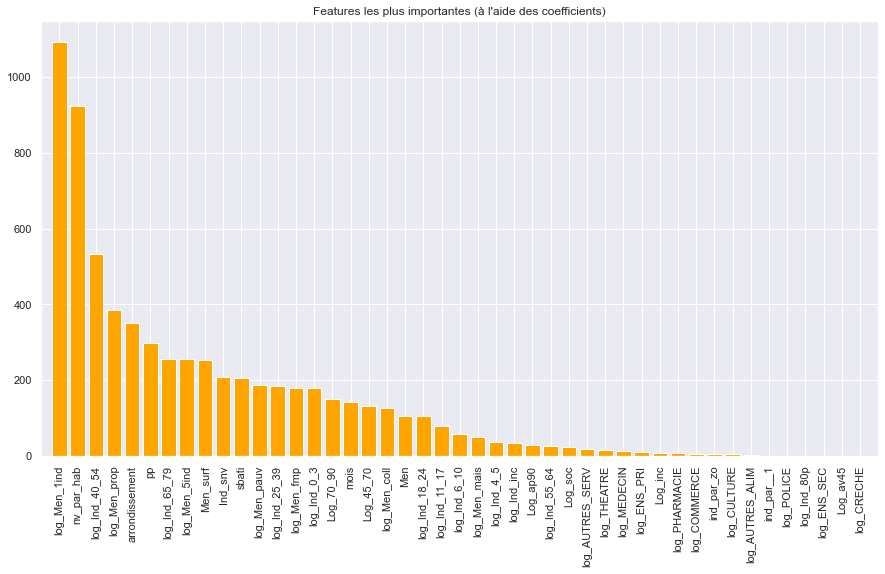

In [205]:
importance_feature= np.abs(lasso.coef_)
indices= np.argsort(importance_feature)[::-1]
lasso_importance_col= train_good_data.iloc[:, indices.tolist()].columns

plt.figure(figsize= (15, 8))

plt.bar(range(train_good_data.shape[1]), importance_feature[indices],
        color= "orange", align= "center")

plt.xticks(range(train_good_data.shape[1]),  lasso_importance_col, rotation= "vertical")
plt.xlim([-1, train_good_data.shape[1]])
plt.title("Features les plus importantes (à l'aide des coefficients)")
plt.show()

Pour chercher à comprendre l'importance des variables à l'aide d'un LassoCV, Sklearn propose d'observer [la valeur des coefficients de la régression](https://scikit-learn.org/dev/auto_examples/feature_selection/plot_select_from_model_diabetes.html). C'est une vue rapide et simple de comment notre modèle considère les variables.

Ici, la variable qui semble la plus importante est **le log du nombre de ménage d'un individu** du carreau dans lequel se situe le logement. Ensuite **le niveau de vie moyen par habitant du carreau** dans lequel se situe le bien immobilier. Aussi, le nombre de pièce semble important avec la variable **pp**. Aussi, la part de personne agés de 40 à 54 ans est aussi une information importante.

Globablement, les variables qui ressortent sont cohérentes avec ce qu'on pourrait penser naturellement pour qualifier la valeur d'un bien surtout à Paris, comme le nombre de pièce, les niveaux de vie etc.

### A l'aide d'un RandomForestRegressor naif

In [206]:
# Feature selection à l'aide d'un RandomForest
rf= RandomForestRegressor(verbose= verbose, n_jobs= n_jobs)\
.fit(train_good_data, train_label)
sf_rf= SelectFromModel(rf, prefit= True)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   56.9s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:  3.0min finished


In [207]:
selected_feat_rf= train_good_data.columns[(sf_rf.get_support())]
print(len(selected_feat_rf))
print(selected_feat_rf)

16
Index(['sbati', 'pp', 'nv_par_hab', 'arrondissement', 'mois', 'log_THEATRE',
       'log_AUTRES_ALIM', 'log_AUTRES_SERV', 'log_COMMERCE', 'log_CRECHE',
       'log_CULTURE', 'log_ENS_PRI', 'log_ENS_SEC', 'log_MEDECIN',
       'log_PHARMACIE', 'log_POLICE'],
      dtype='object')


In [208]:
importance_feature= rf.feature_importances_
std= np.std([i.feature_importances_ for i in rf.estimators_], axis=0)
indices= np.argsort(importance_feature)[::-1]

rf_importance_col= train_good_data.iloc[:, indices.tolist()].columns

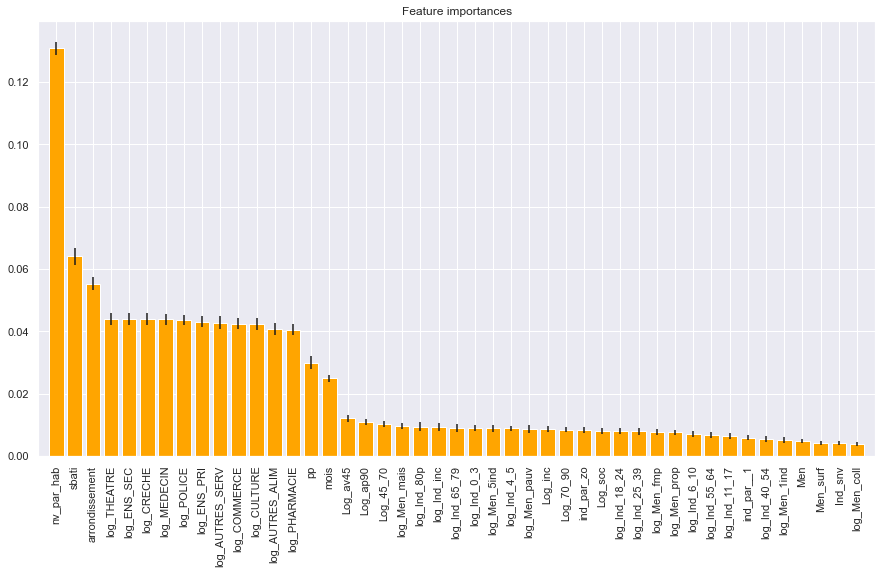

In [209]:
plt.figure(figsize= (15, 8))

plt.title("Feature importances")
plt.bar(range(train_good_data.shape[1]), importance_feature[indices],
        color= "orange", yerr= std[indices], align= "center")
plt.xticks(range(train_good_data.shape[1]),  rf_importance_col, rotation= "vertical")
plt.xlim([-1, train_good_data.shape[1]])
plt.show()

Avec l'utilisation d'un random forest naif, c'est à dire train à la volée, on se rend compte qu'il n'y a que 14 features qui sont sélectionnées. De plus, lorsqu'on regarde les features d'importances du modèle entraîné, on remarque plusieurs éléments :
- toute nos log transformations sont en tête
- l'écart-type (représentée par le trait noir vertical) est fort pour toute les features. (En faite, comme on a 100 arbres qui sont construits, on peut calculer l'écart-type pour chaque variable)
- Etre proche d'un centre de soin, de la police et de la crèche semble cohérent surtout à Paris. Il faudrait néanmoins analyser la distances de ces services pour chaque logement avec au moins 3 individus; l'idée serait de mettre en lien le prix au m² avec le besoin de service à proximité du bien immobilier pour les familles avec enfant.
- la distance à un théatre est intéressant. En effet, on retrouve les théatres dans les quartiers les plus riches, et c'est dans ces mêmes quartiers que les logements valent le plus chère au m² (et ceux même si la corrélation entre ces variables est proche de 0). On peut donc s'attendre à ce que la distance à un théatre proche nous aident à mieux prédire le prix au m².

## Développement de la Pipeline avec XGBoost et LGBoosting

In [210]:
def random_search_pipeline(pipeline, params, scoring, cv, n_iter, train_x, train_y):
    """
    """
    random_search= RandomizedSearchCV(pipeline, param_distributions=params, scoring= scoring
                                      , n_iter=n_iter, verbose= 2, cv= cv, n_jobs= n_jobs
                                      , random_state= 55)

    random_search.fit(train_x, train_y)
    return random_search


def rmse(model, test, label):
    prediction= model.predict(test)
    print("RMSE: %.2f"
          % math.sqrt(np.mean((prediction - label) ** 2)))
    pass

def rmse_adjusted(model, test, label, thresh= 400000):
    prediction= model.predict(test)
    diff= prediction - label
    ndiff= np.where(np.abs(diff) < thresh, diff, np.nan)
    print("Pourcentage de prédiction avec un erreur supérieur à {}: {}"\
          .format(thresh, sum(np.isnan(ndiff))/ndiff.shape[0]))
    new_diff= ndiff[~np.isnan(ndiff)]
    print("RMSE ADJUSTED: %.2f"
          % math.sqrt(np.mean((new_diff) ** 2)))
    pass

def mae(model, test, label):
    prediction= model.predict(test)
    print("MAE: %.2f"
          % np.mean(np.abs(prediction - label)))
    pass


def rmse_compare(model, test, label, sbati):
    prediction= model.predict(test)
    prediction_sbati= prediction * np.exp(sbati)
    label_sbati= label * np.exp(sbati)
    print("RMSE remis au niveau du prix du bien: %.2f"
          % math.sqrt(np.mean((prediction_sbati - label_sbati) ** 2)))
    pass

def feature_importance(model, list_col, train= train):
    importance_feature= model.best_estimator_._final_estimator.feature_importances_
    indices= np.argsort(importance_feature)[::-1]
    xgb_importance_col= train[list_col].iloc[:, indices.tolist()].columns

    plt.figure(figsize= (12, 7))

    plt.title("Feature importances")
    plt.bar(range(train[xgb_importance_col].shape[1]), importance_feature[indices],
            color= "orange", align= "center")
    plt.xticks(range(train[xgb_importance_col].shape[1]),  xgb_importance_col, rotation= "vertical")
    plt.xlim([-1, train[xgb_importance_col].shape[1]])
    plt.show()

### Feature selection RandomForest

In [211]:
def lets_go(df):
    df["arrondissement"] = df["arrondissement"].astype("category")
    df["pp"] = df["pp"].astype("category")
    df["mois"] = df["mois"].astype("category")
    return df

train= lets_go(train)
test= lets_go(test)

In [212]:
# Construction de nos dataset
train_good_data= train[train.columns[~train.columns.isin(useless_col)]].copy()
train_label= train_good_data.pop("prix_m_c")

train_rf= train_good_data.loc[:, selected_feat_rf.tolist()]

test_copy= test.copy()
test_label= test_copy.pop("prix_m_c")
test_rf= test_copy.loc[:, selected_feat_rf.tolist()]

In [213]:
xgb_regressor= xgb.XGBRegressor(eval_metric= "rmse", tree_method= "gpu_hist", predictor= "gpu_predictor")

pipeline_xgb= Pipeline([
    ('standard_scaler', StandardScaler()),
    ('model', xgb_regressor)
])

parameters_for_testing = {
   'model__min_child_weight':[1.5, 6, 10],
   'model__n_estimators':[50, 100, 200, 500],
   'model__learning_rate':[0.02, 0.05, 0.08, 0.1],
#    'model__max_depth':[1, 2, 3, 4, 5, 6, -1],
   'model__reg_alpha':[0.05, 0.01],
   'model__reg_lambda':[0.01, 0.05, 0.1],
   'model__colsample_bytree': [0.3, 0.5, 0.8, 1],
}

lgb_model = LGBMRegressor(objective= "root_mean_squared_error", boosting_type= "gbdt")

pipeline_lgb= Pipeline([
    #('standard_scaler', StandardScaler()),
    ('model', lgb_model)
])

parameters_for_testing_lgb = {
    'model__learning_rate': [0.02, 0.05, 0.08, 0.1],
    'model__n_estimators': [50, 100, 200, 500],
    'model__colsample_bytree' : [0.3, 0.5, 0.8, 1],
    'model__subsample' : [0.4, 0.2, 0.3],
#     'model__max_depth': [1, 2, 3, 4, 5, 6, -1]
    }


XGB avec feature selection de RandomForest

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   39.8s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:  4.0min
[Parallel(n_jobs=10)]: Done 300 out of 300 | elapsed:  8.4min finished


RMSE: 2642.13
Pourcentage de prédiction avec un erreur supérieur à 400000: 0.0
RMSE ADJUSTED: 2642.13
MAE: 1776.14

RMSE du train (pas ouf comme metrique)
RMSE: 2560.92

Mise à l'echelle des autres modèles de la métrique
Train
RMSE remis au niveau du prix du bien: 177872.91
Test
RMSE remis au niveau du prix du bien: 185348.22


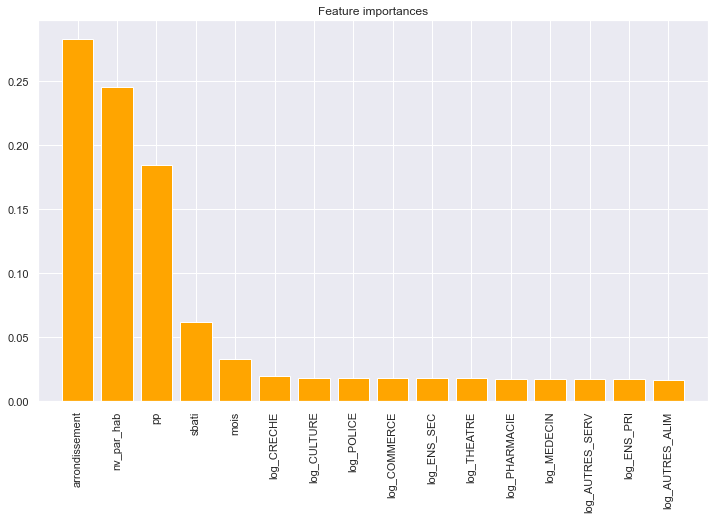

In [214]:
print("XGB avec feature selection de RandomForest\n")
random_search_xgb= random_search_pipeline(pipeline_xgb, parameters_for_testing
                                          , "neg_root_mean_squared_error", 3, 100, train_rf, train_label)

rmse(random_search_xgb, test_rf, test_label)
rmse_adjusted(random_search_xgb, test_rf, test_label)
mae(random_search_xgb, test_rf, test_label)
print("\nRMSE du train (pas ouf comme metrique)")
rmse(random_search_xgb, train_rf, train_label)

print("\nMise à l'echelle des autres modèles de la métrique")
print("Train")
rmse_compare(random_search_xgb, train_rf, train_label, sbati_train)
print("Test")
rmse_compare(random_search_xgb, test_rf, test_label, sbati_test)

feature_importance(random_search_xgb, selected_feat_rf)

LGB avec feature selection de RandomForest

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   26.9s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:  2.5min
[Parallel(n_jobs=10)]: Done 300 out of 300 | elapsed:  5.4min finished


RMSE: 2642.36
Pourcentage de prédiction avec un erreur supérieur à 400000: 0.0
RMSE ADJUSTED: 2642.36
MAE: 1776.93

RMSE du train (pas ouf comme metrique)
RMSE: 2607.66

Mise à l'echelle des autres modèles de la métrique
Train
RMSE remis au niveau du prix du bien: 183628.91
Test
RMSE remis au niveau du prix du bien: 185818.93


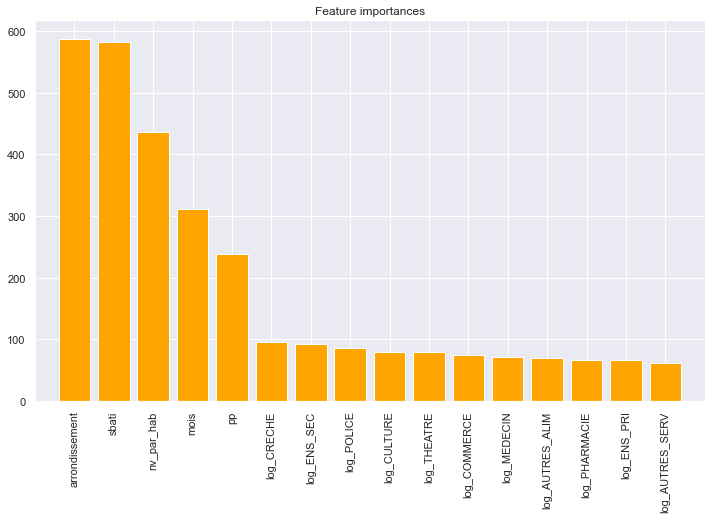

In [215]:
print("LGB avec feature selection de RandomForest\n")
random_search_lgb= random_search_pipeline(pipeline_lgb, parameters_for_testing_lgb
                                          , "neg_mean_squared_error", 3, 100, train_rf, train_label)

rmse(random_search_lgb, test_rf, test_label)
rmse_adjusted(random_search_lgb, test_rf, test_label)
mae(random_search_lgb, test_rf, test_label)
print("\nRMSE du train (pas ouf comme metrique)")
rmse(random_search_lgb, train_rf, train_label)

print("\nMise à l'echelle des autres modèles de la métrique")
print("Train")
rmse_compare(random_search_lgb, train_rf, train_label, sbati_train)
print("Test")
rmse_compare(random_search_lgb, test_rf, test_label, sbati_test)

feature_importance(random_search_lgb, selected_feat_rf)

### Feature selection Lasso

In [216]:
# constrution de nos dataset
train_good_data= train[train.columns[~train.columns.isin(useless_col)]].copy()
train_label= train_good_data.pop("prix_m_c")
train_rf= train_good_data.loc[:, selected_feat_lasso.tolist()]

test_copy= test.copy()
test_label= test_copy.pop("prix_m_c")
test_rf= test_copy.loc[:, selected_feat_lasso.tolist()]

XGB avec feature selection de RandomForest

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   42.2s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:  5.0min
[Parallel(n_jobs=10)]: Done 300 out of 300 | elapsed: 11.0min finished


RMSE: 2609.44
Pourcentage de prédiction avec un erreur supérieur à 400000: 0.0
RMSE ADJUSTED: 2609.44
MAE: 1741.53

RMSE du train (pas ouf comme metrique)
RMSE: 2524.19

Mise à l'echelle des autres modèles de la métrique
Train
RMSE remis au niveau du prix du bien: 173293.80
Test
RMSE remis au niveau du prix du bien: 182008.05


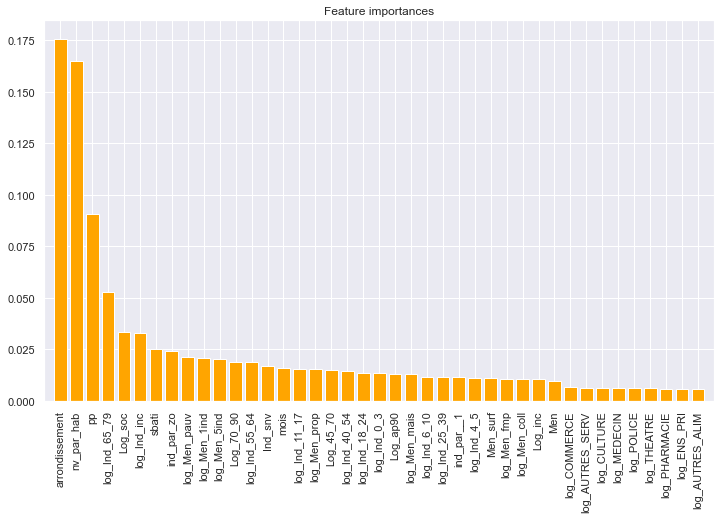

In [217]:
print("XGB avec feature selection de RandomForest\n")
random_search_xgb= random_search_pipeline(pipeline_xgb, parameters_for_testing
                                          , "neg_root_mean_squared_error", 3, 100, train_rf, train_label)

rmse(random_search_xgb, test_rf, test_label)
rmse_adjusted(random_search_xgb, test_rf, test_label)
mae(random_search_xgb, test_rf, test_label)
print("\nRMSE du train (pas ouf comme metrique)")
rmse(random_search_xgb, train_rf, train_label)

print("\nMise à l'echelle des autres modèles de la métrique")
print("Train")
rmse_compare(random_search_xgb, train_rf, train_label, sbati_train)
print("Test")
rmse_compare(random_search_xgb, test_rf, test_label, sbati_test)

feature_importance(random_search_xgb, selected_feat_lasso)

LGB avec feature selection de Lasso

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   40.1s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:  4.1min
[Parallel(n_jobs=10)]: Done 300 out of 300 | elapsed:  8.9min finished


RMSE: 2611.22
Pourcentage de prédiction avec un erreur supérieur à 400000: 0.0
RMSE ADJUSTED: 2611.22
MAE: 1744.03

RMSE du train (pas ouf comme metrique)
RMSE: 2544.02

Mise à l'echelle des autres modèles de la métrique
Train
RMSE remis au niveau du prix du bien: 176371.08
Test
RMSE remis au niveau du prix du bien: 181878.93


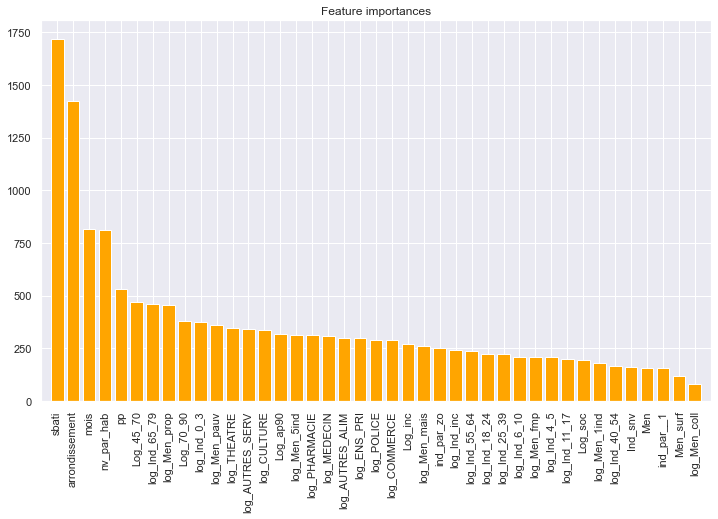

In [218]:
print("LGB avec feature selection de Lasso\n")
random_search_lgb= random_search_pipeline(pipeline_lgb, parameters_for_testing_lgb
                                          , "neg_mean_squared_error", 3, 100, train_rf, train_label)
rmse(random_search_lgb, test_rf, test_label)
rmse_adjusted(random_search_lgb, test_rf, test_label)
mae(random_search_lgb, test_rf, test_label)
print("\nRMSE du train (pas ouf comme metrique)")
rmse(random_search_lgb, train_rf, train_label)

print("\nMise à l'echelle des autres modèles de la métrique")
print("Train")
rmse_compare(random_search_lgb, train_rf, train_label, sbati_train)
print("Test")
rmse_compare(random_search_lgb, test_rf, test_label, sbati_test)

feature_importance(random_search_lgb, selected_feat_lasso)

### Sans feature selection

In [223]:
listed= [i for i in train.columns[~train.columns.isin(useless_col)]]

train_good_data= train[listed].copy()
train_label= train_good_data.pop("prix_m_c")
train_rf= train_good_data

test_copy= test[listed].copy()
test_label= test_copy.pop("prix_m_c")
test_rf= test_copy

XGB avec feature selection de RandomForest

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   43.6s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:  5.3min
[Parallel(n_jobs=10)]: Done 300 out of 300 | elapsed: 11.5min finished


RMSE: 2610.12
Pourcentage de prédiction avec un erreur supérieur à 400000: 0.0
RMSE ADJUSTED: 2610.12
MAE: 1741.15

RMSE du train (pas ouf comme metrique)
RMSE: 2520.41

Mise à l'echelle des autres modèles de la métrique
Train
RMSE remis au niveau du prix du bien: 173362.50
Test
RMSE remis au niveau du prix du bien: 182102.68


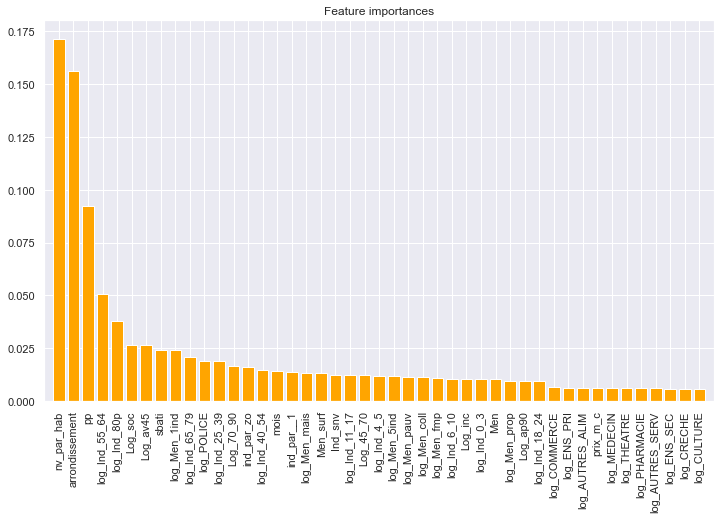

In [224]:
print("XGB avec feature selection de RandomForest\n")
random_search_xgb= random_search_pipeline(pipeline_xgb, parameters_for_testing
                                          , "neg_root_mean_squared_error", 3, 100, train_rf, train_label)

rmse(random_search_xgb, test_rf, test_label)
rmse_adjusted(random_search_xgb, test_rf, test_label)
mae(random_search_xgb, test_rf, test_label)
print("\nRMSE du train (pas ouf comme metrique)")
rmse(random_search_xgb, train_rf, train_label)

print("\nMise à l'echelle des autres modèles de la métrique")
print("Train")
rmse_compare(random_search_xgb, train_rf, train_label, sbati_train)
print("Test")
rmse_compare(random_search_xgb, test_rf, test_label, sbati_test)

feature_importance(random_search_xgb, listed)

LGB sans feature selection

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   44.4s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:  4.3min
[Parallel(n_jobs=10)]: Done 300 out of 300 | elapsed:  9.1min finished


RMSE: 2612.31
Pourcentage de prédiction avec un erreur supérieur à 400000: 0.0
RMSE ADJUSTED: 2612.31
MAE: 1744.53

RMSE du train (pas ouf comme metrique)
RMSE: 2546.53

Mise à l'echelle des autres modèles de la métrique
Train
RMSE remis au niveau du prix du bien: 176976.99
Test
RMSE remis au niveau du prix du bien: 182179.06


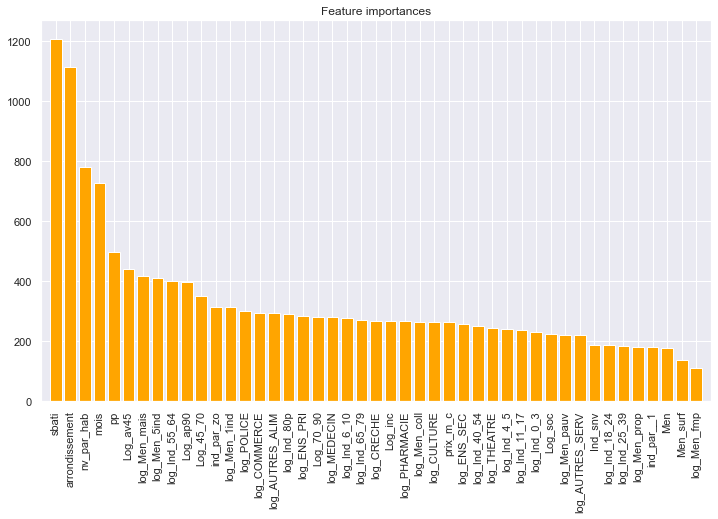

In [225]:
print("LGB sans feature selection\n")
random_search_lgb= random_search_pipeline(pipeline_lgb, parameters_for_testing_lgb
                                          , "neg_mean_squared_error", 3, 100, train_rf, train_label)

rmse(random_search_lgb, test_rf, test_label)
rmse_adjusted(random_search_lgb, test_rf, test_label)
mae(random_search_lgb, test_rf, test_label)
print("\nRMSE du train (pas ouf comme metrique)")
rmse(random_search_lgb, train_rf, train_label)

print("\nMise à l'echelle des autres modèles de la métrique")
print("Train")
rmse_compare(random_search_lgb, train_rf, train_label, sbati_train)
print("Test")
rmse_compare(random_search_lgb, test_rf, test_label, sbati_test)

feature_importance(random_search_lgb, listed)